In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import networkx as nx
import scipy.sparse as sp
from graphite_maps.enif import EnIF
import graphite_maps.precision_estimation as precest
from tqdm import tqdm

In [5]:
def L96(x, t, F=8):
    """Lorenz 96 model with constant forcing"""
    # Setting up vector
    p = len(x)
    d = np.zeros(p)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(p):
        d[i] = (x[(i + 1) % p] - x[i - 2]) * x[i - 1] - x[i] + F
    return d

def L96_graph(K, p=40):
    """
    K: int Markov order, i.e. maximum difference to create an edge 
    """

    # Create an empty undirected graph
    Graph_u = nx.Graph()
    
    # Add vertices
    Graph_u.add_nodes_from(range(p))

    ## Add edges, considering the L96 equation and RK4
    #for j in range(p):
    #    for k in range(p):
            
    
    # Add edges, considering the graph as a ring
    for j in range(p):
        for k in range(p):
            if j != k and abs(j - k) % (p - K) <= K:
                Graph_u.add_edge(j, k)

    return Graph_u

def rk4(f, y0, t, args=()):
    """Runge-Kutta method or order 4"""
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0
    for i in range(n - 1):
        h = t[i+1] - t[i]
        k1 = f(y[i], t[i], *args)
        k2 = f(y[i] + k1 * h / 2., t[i] + h / 2., *args)
        k3 = f(y[i] + k2 * h / 2., t[i] + h / 2., *args)
        k4 = f(y[i] + k3 * h, t[i] + h, *args)
        y[i+1] = y[i] + (h / 6.) * (k1 + 2*k2 + 2*k3 + k4)
    return y

COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_ensemble(Ensemble, d_ind, d_obs, prior_mean=None):
    n, p = Ensemble.shape
    u_position = [j for j in range(p)]
    ensemble_mean = np.array(Ensemble.mean(axis=0))
    num_plots = 3 if prior_mean is None else 4
    
    fig = plt.figure(figsize=(16, 4))
    fig.suptitle('Ensemble inspection & observation', fontsize=16)

    ax = fig.add_subplot(1,num_plots,1)
    ax.plot(u_position, Ensemble[0,:])
    ax.plot(d_ind, d_obs, marker='*', ls='none', ms=20)
    ax.set_title('Realization #1')
    
    ax = fig.add_subplot(1,num_plots,2)
    for i in range(n):
        ax.plot(u_position, Ensemble[i,:], label= "realization {ind}".format(ind=i), color=COLORS[0], alpha=0.1)
    ax.set_title('All realizations')
    ax.plot(d_ind, d_obs, marker='*', ls='none', ms=20, color=COLORS[1])
    
    ax = fig.add_subplot(1,num_plots,3)
    ax.plot(u_position, ensemble_mean)
    ax.plot(d_ind, d_obs, marker='*', ls='none', ms=20)
    ax.set_title('Ensemble mean')

    if num_plots == 4:
        ax = fig.add_subplot(1,num_plots,4)
        ax.plot(u_position, ensemble_mean - prior_mean)
        ax.set_title('Posterior mean - prior mean')
    plt.show()

def plot_l96(y, time_observe, dt, dim1=0, dim2=1, dim3=2):
    """Plot evolution of y over time on three dimensions"""

    fig = plt.figure()
    fig.patch.set_facecolor('white')  # Set the background color of the figure to white
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot first part in one color (e.g., 'blue')
    ind_observe = int(time_observe/dt)
    ax.plot(y[0:ind_observe, dim1], y[0:ind_observe, dim2], y[0:ind_observe, dim3], color='black')
    
    # Plot second part in another color (e.g., 'red')
    ax.plot(y[(ind_observe-1):, dim1], y[(ind_observe-1):, dim2], y[(ind_observe-1):, dim3], color='darkorange')
    
    # Set labels
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_zlabel("$x_3$")
    
    # Reduce the number of ticks on each axis
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.zaxis.set_major_locator(plt.MaxNLocator(5))
    
    # Set the background color of the axes
    ax.set_facecolor('white')
    
    # Turn off the grid on the panes
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    
    plt.show()

def kf_update(y, H, Sigma, mu , Sigma_y):
    """Kalman filter update"""
    K = Sigma @ H.T @ np.linalg.inv(H@Sigma@H.T + Sigma_y)
    y_pred = H @ mu
    mu_posterior = mu + K @ (y - y_pred)
    return mu_posterior

def EnKF_update(U, H, Sigma_y):
    n, p = U.shape
    for i in range(n):
        # perturb i
        noise = np.random.normal(0, np.sqrt(cov_y[0,0]))
        y_perturbed = y + noise
        # use realization as expectation
        mu_x_i = X[i,].reshape(T,1)
        # update each realization
        mu_post = kf_update(y_perturbed, H, cov_x_sample, mu_x_i, cov_y)
        X_posterior[i,:] = mu_post.reshape(1,T)

def nll_gauss(U, Prec, aic=True, nz=None):
    n, p = U.shape
    S = np.cov(U.T)
    (_, prec_logabsdet) = np.linalg.slogdet(Prec.A)
    res = 0.5 * (
        np.trace(S@Prec) - prec_logabsdet
    )
    if not aic:
        return res
    else:
        if nz is None:
            nz = len(Prec.nonzero()[0])
        df = (nz + p) / 2.0
        #return res + 0.5 * df * np.log(n) / n # bic
        return res + df / n # aic

def mean_squared_error(predictions, true_values):
    """
    Compute the mean squared error between predictions and true values.

    :param predictions: numpy array of shape (n, p) containing predictions.
    :param true_values: numpy array of shape (p,) containing true values.
    :return: Mean squared error.
    """
    # Replicate true_values to match the shape of predictions
    true_values_replicated = np.tile(true_values, (predictions.shape[0], 1))

    # Compute mean squared error
    mse = np.mean((predictions - true_values_replicated) ** 2, axis=1)
    return mse


def relative_kld_transport(U, Prec_u):
    """Calculate sum of training loss on C and AIC penalty for that term"""
    n, p = U.shape

    # Create the reverse order permutation array
    perm_reverse = np.arange(p - 1, -1, -1)
    # Create the reverse permutation matrix
    P_rev = sp.csc_matrix(
        (np.ones(p), (perm_reverse, np.arange(p))), shape=(p, p)
    )

    

In [6]:
# Set seed
rng = np.random.default_rng(12345)

# These are our constants
n = 100
p = 40  # Number of variables
F = 8  # Forcing
time_observe = 1.0
time_forecast = 0.1
dt = 0.01
t_simulate = np.arange(0.0, time_observe, dt)
t_forecast = np.arange(time_observe, time_observe + time_forecast, dt)
t_full = np.arange(0.0, time_observe + time_forecast, dt)

In [7]:
# Simulate synthetic truth
y0 = F * np.ones(p)  # Initial state (equilibrium)
y0_sd = 0.01
y0 += y0_sd * rng.standard_normal(size=(p))
#y = odeint(L96, y0, t_full)
y = rk4(L96, y0, t_full)
indices_all = np.arange(0,p-1,1)
obs_spacing = 10
train_condition = indices_all % obs_spacing == 0
#train_condition = ((5 < indices_all) & (indices_all < 15)) | ((25 < indices_all) & (indices_all < 35))
indices_train = indices_all[train_condition]
indices_test = indices_all[~train_condition]
d = y[int(time_observe/dt)-1,indices_train]# every other dimension
d_test = y[int((time_observe+time_forecast)/dt)-1,:]

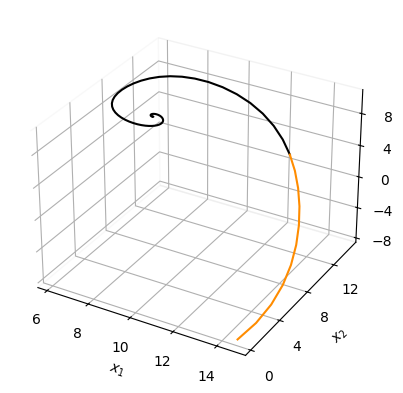

In [8]:
fig = plt.figure()
fig.patch.set_facecolor('white')  # Set the background color of the figure to white
ax = fig.add_subplot(111, projection='3d')

# Plot first part in one color (e.g., 'blue')
ind_observe = int(time_observe/dt)
ax.plot(y[0:ind_observe, 0], y[0:ind_observe, 1], y[0:ind_observe, 2], color='black')

# Plot second part in another color (e.g., 'red')
ax.plot(y[(ind_observe-1):, 0], y[(ind_observe-1):, 1], y[(ind_observe-1):, 2], color='darkorange')

# Set labels
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")

# Reduce the number of ticks on each axis
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))
ax.zaxis.set_major_locator(plt.MaxNLocator(5))

# Set the background color of the axes
ax.set_facecolor('white')

# Turn off the grid on the panes
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

plt.show()

In [9]:
# Sample many realizations
U = np.empty(shape=(n,p))
for i in tqdm(range(n)):
    u0 = F * np.ones(p)  # Initial state (equilibrium)
    u0 += 0.01 * rng.standard_normal(size=(p))
    u = rk4(L96, u0, t_simulate)
    U[i,:] = u[-1,:]# + eps_sd * rng.standard_normal(size=(p))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 129.67it/s]


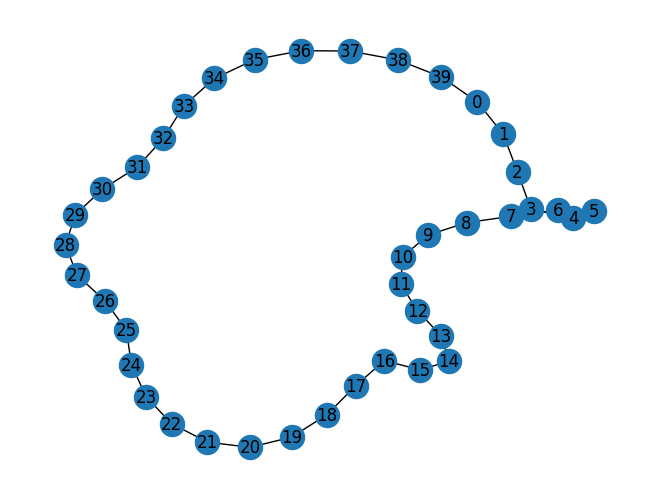

In [10]:
# Create graph
Graph_u = L96_graph(K=1)

# Visualize the graph
nx.draw(Graph_u, with_labels=True)
plt.show()

In [11]:
# Create observation precision
m = d.shape[0]

# Creating an H matrix of zeros with shape (m, p)
H = np.zeros((m, p))

# Setting one element in each row to 1
for i in range(m):
    H[i, indices_train[i]] = 1
H = sp.csc_matrix(H)



# Construct uncertainty about observations -- a way to build in model error
var_eps = 1.0 * 1e-0
Prec_eps = np.eye(m) / var_eps
Prec_eps = sp.csc_matrix(Prec_eps)

In [12]:
Y = U @ H.T
Y.shape

(100, 4)

In [13]:
gtmap = EnIF(Graph_u = Graph_u, Prec_eps=Prec_eps, H=H)
gtmap.fit(U)
U_posterior = gtmap.transport(U, Y, d, verbose_level=5)

/Users/BERL/Github/venv_sksparse/lib/python3.11/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
Learning precision Cholesky factor row-by-row: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 1182.73it/s]

Mapping realizations to canonical space
Calculating unexplained variance
Calculating response residuals
Sampling with seed=None
Sampled Gaussian noise with shape (100, 4)
Total residual variance: 4.0
Unexplained variance: 0.0
Measurement variance: 4.0
Mapping canonical-scaled realizations to moment realization


In [14]:
# Simulate prior to evaluation time
U_prior_forecast = np.empty(shape=U.shape)
for i in range(U.shape[0]):
    u = odeint(L96, U[i,:], t_forecast)
    U_prior_forecast[i,:] = u[-1,:]

# Simulation posterior to evaluation time
U_posterior_forecast = np.empty(shape=U.shape)
for i in range(U.shape[0]):
    u = odeint(L96, U_posterior[i,:], t_forecast)
    U_posterior_forecast[i,:] = u[-1,:]

In [15]:
# Simulate prior to evaluation time
U_prior_forecast = np.empty(shape=U.shape)
for i in range(U.shape[0]):
    u = odeint(L96, U[i,:], t_forecast)
    U_prior_forecast[i,:] = u[-1,:]

# Simulation posterior to evaluation time
U_posterior_forecast = np.empty(shape=U.shape)
for i in range(U.shape[0]):
    u = odeint(L96, U_posterior[i,:], t_forecast)
    U_posterior_forecast[i,:] = u[-1,:]

## Replication of experiment of Ramgraber 2023

In [57]:
# Replicate experiment of Ramgraber 2023

# Ensemble size
n = 500

# Lorenz-96 system constants
p = 40  # Number of variables
F = 8  # Forcing

# Time variables
T_spinup = 10 # Spinup period
T = 10 # Assimilation time steps
dt_obs = 0.4 # Time step between observations
nt = 40 # number of integration time-points between observations
dt_integrate = dt_obs/nt
time_spinup = dt_obs * T_spinup
time_forecast = dt_obs * T
time_full = time_spinup + time_forecast
time_spinup_grid = np.arange(0.0, time_spinup, dt_integrate)
time_forecast_full_grid = np.arange(time_spinup, time_full, dt_integrate)
time_forecast_grid = np.arange(0.0, dt_obs, dt_integrate)

# Observations we train from
indices_all = np.arange(0,p,1)
obs_spacing = p
train_condition = indices_all % obs_spacing == 0
#train_condition = ((5 < indices_all) & (indices_all < 15)) | ((25 < indices_all) & (indices_all < 35))
indices_train = indices_all[train_condition]
indices_test = indices_all[~train_condition]
m = len(indices_train)

# Create corresponding linear map
H = np.zeros((m, p))
for i in range(m):
    H[i, indices_train[i]] = 1
H = sp.csc_matrix(H)

# Observation error
m = len(indices_train)
var_eps = 0.5 # sd=0.25 in paper, but np.sqrt(0.5) in code
Prec_eps = np.eye(m) / var_eps
Prec_eps = sp.csc_matrix(Prec_eps)

In [58]:
# Simulate truth

# Set seed
rng = np.random.default_rng(123)

# 1. Spinup period
y0_spinup = F * np.ones(p)
y0_spinup_sd = 0.01
y0_spinup += y0_spinup_sd * rng.standard_normal(size=(p))
#y = odeint(L96, y0_spinup, t_full)
y_spinup = rk4(L96, y0_spinup, time_spinup_grid)

# 2. Forecast period
y0 = y_spinup[-1,:]
y = rk4(L96, y0, time_forecast_full_grid)
print(y.shape)

# Pick out observations from truth
y_test = y[::nt,:]
d = y_test[:,indices_train]
d += np.sqrt(var_eps) * rng.standard_normal(size=d.shape)
print(d.shape)

(400, 40)
(10, 1)


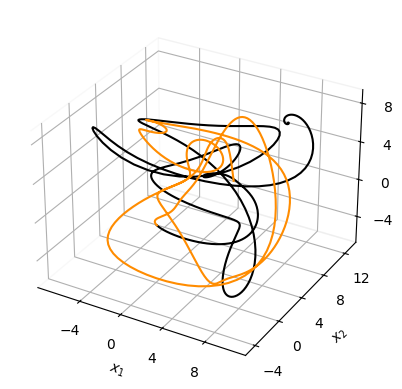

In [59]:
plot_l96(np.concatenate((y_spinup, y)), time_spinup, dt_integrate) 

In [60]:
# Spinup ensembles 
U = np.zeros(shape=(n,p,T))
for i in tqdm(range(n)):
    u0 = F * np.ones(p)
    u0 += 0.01 * rng.standard_normal(size=(p))
    u = rk4(L96, u0, time_spinup_grid)
    U[i,:,0] = u[-1,:]

U_sim = U.copy()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:13<00:00, 38.02it/s]


In [61]:
# Create a test-set
# Spinup ensembles 
U_te = np.zeros(shape=(n,p))
for i in tqdm(range(U_te.shape[0])):
    u0 = F * np.ones(p)
    u0 += 0.01 * rng.standard_normal(size=(p))
    u = rk4(L96, u0, time_spinup_grid)
    U_te[i,:] = u[-1,:]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 38.58it/s]


Learning precision Cholesky factor row-by-row: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 786.64it/s]


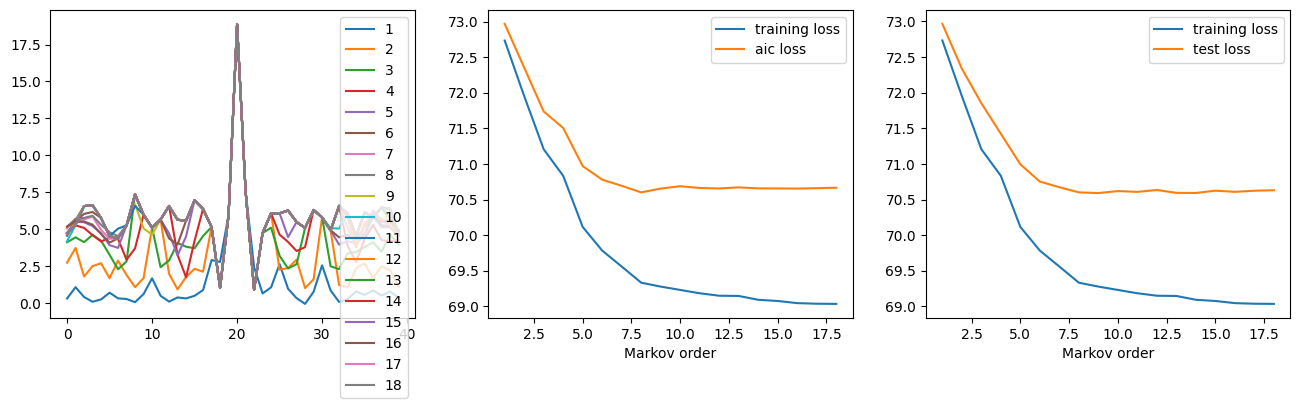

In [62]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1,3,1)
cov_u_ml = np.cov(U[:,:,0].T)

markov_orders = np.arange(1,19,1)
loss_tr, loss_aic, loss_te = [], [], []

for markov_order in markov_orders:
    # fit GMRF at time 0
    Graph_u = L96_graph(K=markov_order, p=p)
    gtmap = EnIF(Graph_u = Graph_u, Prec_eps=Prec_eps, H=H)
    gtmap.fit(U[:,:,0])
    
    # transport
    #U_posterior = np.zeros(U.shape)
    #U_posterior[:,:,0] = gtmap.transport(U[:,:,0], d[0,:])

    # find cov
    cov_u = np.linalg.inv(gtmap.Prec_u.A)

    # plot
    ax.plot(np.arange(p), cov_u[int(p/2),:], label=markov_order)

    # calculate training and aic loss
    # note: without infill
    #nz = p
    #for j in range(1, markov_order+1, 1):
    #    nz += 2 * (p-j)
    #print(nz)
    loss_tr.append(nll_gauss(U[:,:,0], gtmap.Prec_u, False))
    loss_aic.append(nll_gauss(U[:,:,0], gtmap.Prec_u, True))
    loss_te.append(nll_gauss(U_te, gtmap.Prec_u, False))
ax.legend()

ax = fig.add_subplot(1,3,2)
ax.plot(markov_orders, loss_tr, label="training loss")
ax.plot(markov_orders, loss_aic, label="aic loss")
ax.set_xlabel("Markov order")
ax.legend()

ax = fig.add_subplot(1,3,3)
ax.plot(markov_orders, loss_tr, label="training loss")
ax.plot(markov_orders, loss_te, label="test loss")
ax.set_xlabel("Markov order")
ax.legend()

plt.show()

## Only measuring KLD on P from Q

Learning precision Cholesky factor row-by-row: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 446.17it/s]


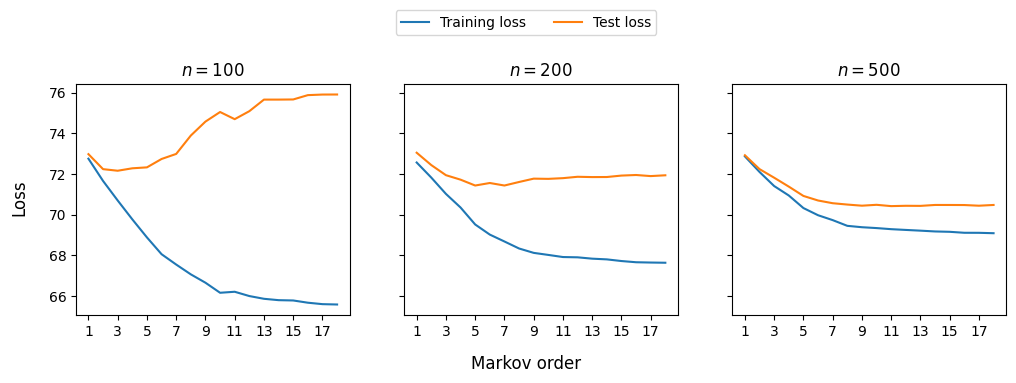

In [72]:
# Replicate parts of experiment of Ramgraber 2023

# Ensemble size
n_sizes = [100, 200, 500,]

# Lorenz-96 system constants
p = 40  # Number of variables
F = 8  # Forcing

# Time variables
T_spinup = 10 # Spinup period
T = 10 # Assimilation time steps
dt_obs = 0.4 # Time step between observations
nt = 40 # number of integration time-points between observations
dt_integrate = dt_obs/nt
time_spinup = dt_obs * T_spinup
time_spinup_grid = np.arange(0.0, time_spinup, dt_integrate)

# Set up matplotlib with three horizontal plots
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
#fig = plt.figure(figsize=(16, 4))
#ax = fig.add_subplot(1,3,1)

# iterate over ns
for j, n in enumerate(n_sizes):
    # Create a training and test set
    U_tr = np.zeros(shape=(n,p))
    for i in tqdm(range(n)):
        u0 = F * np.ones(p)
        u0 += 0.01 * rng.standard_normal(size=(p))
        u = rk4(L96, u0, time_spinup_grid)
        U_tr[i,:] = u[-1,:]
    U_te = np.zeros(shape=(n,p))
    for i in tqdm(range(U_te.shape[0])):
        u0 = F * np.ones(p)
        u0 += 0.01 * rng.standard_normal(size=(p))
        u = rk4(L96, u0, time_spinup_grid)
        U_te[i,:] = u[-1,:]

    # Calculate loss over increasing Markov order
    markov_orders = np.arange(1,19,1)
    loss_tr, loss_aic, loss_te = [], [], []
    for markov_order in markov_orders:
        # fit GMRF at time 0
        Graph_u = L96_graph(K=markov_order, p=p)
        gtmap = EnIF(Graph_u = Graph_u, Prec_eps=Prec_eps, H=H)
        gtmap.fit(U_tr)
        loss_tr.append(nll_gauss(U_tr, gtmap.Prec_u, False))
        loss_te.append(nll_gauss(U_te, gtmap.Prec_u, False))

    #plot_subplot(axes[0], u_position, d, U0, U_posterior0, U_posterior_es0, U_posterior_enif0, n)
    axes[j].set_title(f'$n=${n}')
    
    axes[j].plot(markov_orders, loss_tr, label="Training loss")
    axes[j].plot(markov_orders, loss_te, label="Test loss")
    axes[j].set_xticks(np.arange(int(min(markov_orders)), int(max(markov_orders)) + 1, 2))


# Create a common legend for all subplots, placed outside the plot
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)

# Set common x and y labels
fig.text(0.5, -0.07, 'Markov order', ha='center', fontsize=12)
fig.text(0.07, 0.5, 'Loss', va='center', rotation='vertical', fontsize=12)

# Save the figure
if True:
    plt.savefig("lorenz_96_markov_order_vs_sample_size.pdf", format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


In [65]:
len(n)

3

# Graph induced by Lorenz-96 dnamics and integration schemes

In [325]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def map_to_range(n):
    return ((n - 1) % 40) + 1

def fetch_or_largest(nodes_right, i):
    if i < len(nodes_right):
        return nodes_right[i]
    else:
        return max(nodes_right)


COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

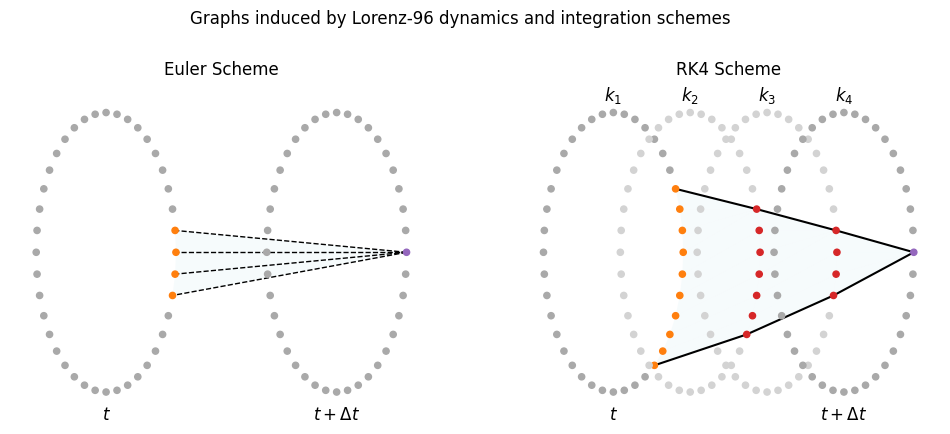

In [324]:
# Number of nodes
n_nodes = 40

# Create a circular graph
G = nx.Graph()

# Add nodes
nodes = list(range(1, n_nodes + 1))
G.add_nodes_from(nodes)

# Add edges for neighbors (+1 and -1) without drawing them
edges = [(i, (i % n_nodes) + 1) for i in nodes]  # Connect i to i+1 (circular)
edges += [(i, i - 1 if i > 1 else n_nodes) for i in nodes]  # Connect i to i-1 (circular)
G.add_edges_from(edges)

# Draw the graph in a more elliptical layout
pos1 = nx.circular_layout(G)  # Get the circular layout
# Scale the y positions to make the graph elliptical
for key, (x, y) in pos1.items():
    pos1[key] = (x, y * 2.0)  # Make it elliptical (skinnier and higher)

pos2 = pos1.copy()
offset = 1.1
for key, (x, y) in pos2.items():
    pos2[key] = (x+offset, y)
pos3 = pos1.copy()
for key, (x, y) in pos3.items():
    pos3[key] = (x+2*offset, y)
pos4 = pos1.copy()
for key, (x, y) in pos4.items():
    pos4[key] = (x+3*offset, y)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Set fixed aspect ratio (ax.set_aspect) and set axis limits to prevent autoscaling
axes[0].set_aspect(1.00)  # Adjust aspect ratio to maintain elliptical look
axes[1].set_aspect(1.00)

# Draw edges (lines) between black node (node 1) and orange nodes (40, 39, 1, 2)
linecolor = "black"
## start of RK4 scheme
#for target_node in [40, 39, 1, 2]:
#    x_values = [pos4[1][0], pos3[target_node][0]]
#    y_values = [pos4[1][1], pos3[target_node][1]]
#    plt.plot(x_values, y_values, linewidth=1, color=linecolor)

# Euler scheme
for target_node in [40, 39, 1, 2]:
    x_values = [pos4[1][0], pos1[target_node][0]]
    y_values = [pos4[1][1], pos1[target_node][1]]
    axes[0].plot(x_values, y_values, linewidth=1, color=linecolor, linestyle="dashed")

plt.plot([pos4[1][0], pos3[39][0]], [pos4[1][1], pos3[39][1]], color=linecolor)
plt.plot([pos4[1][0], pos3[2][0]], [pos4[1][1], pos3[2][1]], color=linecolor)

plt.plot([pos3[39][0], pos2[37][0]], [pos3[39][1], pos2[37][1]], color=linecolor)
plt.plot([pos2[37][0], pos1[35][0]], [pos2[37][1], pos1[35][1]], color=linecolor)

plt.plot([pos3[2][0], pos2[3][0]], [pos3[2][1], pos2[3][1]], color=linecolor)
plt.plot([pos2[3][0], pos1[4][0]], [pos2[3][1], pos1[4][1]], color=linecolor)

pos = {
    4: pos4,
    3: pos3,
    2: pos2,
    1: pos1,
}

# Euler
nodes_right = [1]
nodes_left = [-1, 0, 1, 2]
for i in range(len(nodes_left)-1):
    lnode_low = nodes_left[i]
    lnode_high = nodes_left[i+1]
    rnode_low = fetch_or_largest(nodes_right, i)
    rnode_high = fetch_or_largest(nodes_right, i+1)
    rectanglex = [pos[1][map_to_range(lnode_low)][0], pos[1][map_to_range(lnode_high)][0],
                  pos[4][map_to_range(rnode_high)][0], pos[4][map_to_range(rnode_low)][0]]
    rectangley = [pos[1][map_to_range(lnode_low)][1], pos[1][map_to_range(lnode_high)][1],
                  pos[4][map_to_range(rnode_high)][1], pos[4][map_to_range(rnode_low)][1]]
    axes[0].fill(rectanglex, rectangley, facecolor=("lightblue",0.1), edgecolor=("lightblue",0.0))


# RK4
nodes_right = [1]
for k in [3,2,1]:
    #print(k)
    # nodes left are set
    # get nodes to the left: all that are to the left, and one up and two down
    nodes_left = nodes_right.copy()
    rnode_max = max(nodes_right)
    rnode_min = min(nodes_right)
    nodes_left.append(rnode_min-1)
    nodes_left.append(rnode_min-2)
    nodes_left.append(rnode_max+1)
    nodes_left.sort()
    #print(nodes_left)

    # draw rectangles
    for i in range(len(nodes_left)-1):
        lnode_low = nodes_left[i]
        lnode_high = nodes_left[i+1]
        rnode_low = fetch_or_largest(nodes_right, i)
        rnode_high = fetch_or_largest(nodes_right, i+1)
        rectanglex = [pos[k][map_to_range(lnode_low)][0], pos[k][map_to_range(lnode_high)][0],
                      pos[k+1][map_to_range(rnode_high)][0], pos[k+1][map_to_range(rnode_low)][0]]
        rectangley = [pos[k][map_to_range(lnode_low)][1], pos[k][map_to_range(lnode_high)][1],
                      pos[k+1][map_to_range(rnode_high)][1], pos[k+1][map_to_range(rnode_low)][1]]
        axes[1].fill(rectanglex, rectangley, facecolor=("lightblue",0.1), edgecolor=("lightblue",0.0))

    nodes_right = nodes_left


# Draw nodes only
node_colors1 = [COLORS[1] if i in [40, 39, 1, 2] else "darkgray" for i in nodes]
nx.draw(G, pos1, with_labels=False, node_size=20, node_color=node_colors1, font_size=10, font_weight='bold', edge_color='none', ax=axes[0])
#node_colors2 = [COLORS[3] if i in [40, 39, 38, 37, 1, 2, 3] else 'lightgray' for i in nodes]
#nx.draw(G, pos2, with_labels=False, node_size=20, node_color=node_colors2, font_size=10, font_weight='bold', edge_color='none', ax=axes[0])

#node_colors3 = [COLORS[3] if i in [40, 39, 1, 2] else 'lightgray' for i in nodes]
#nx.draw(G, pos3, with_labels=False, node_size=20, node_color=node_colors3, font_size=10, font_weight='bold', edge_color='none', ax=axes[0])
node_colors4 = [COLORS[4] if i == 1 else 'darkgray' for i in nodes]
nx.draw(G, pos4, with_labels=False, node_size=20, node_color=node_colors4, font_size=10, font_weight='bold', edge_color='none', ax=axes[0])


node_colors1 = [COLORS[1] if i in [40, 39, 38, 37, 36, 35, 1, 2, 3, 4] else 'darkgray' for i in nodes]
nx.draw(G, pos1, with_labels=False, node_size=20, node_color=node_colors1, font_size=10, font_weight='bold', edge_color='none', ax=axes[1])
node_colors2 = [COLORS[3] if i in [40, 39, 38, 37, 1, 2, 3] else 'lightgray' for i in nodes]
nx.draw(G, pos2, with_labels=False, node_size=20, node_color=node_colors2, font_size=10, font_weight='bold', edge_color='none', ax=axes[1])

node_colors3 = [COLORS[3] if i in [40, 39, 1, 2] else 'lightgray' for i in nodes]
nx.draw(G, pos3, with_labels=False, node_size=20, node_color=node_colors3, font_size=10, font_weight='bold', edge_color='none', ax=axes[1])
node_colors4 = [COLORS[4] if i == 1 else 'darkgray' for i in nodes]
nx.draw(G, pos4, with_labels=False, node_size=20, node_color=node_colors4, font_size=10, font_weight='bold', edge_color='none', ax=axes[1])


# Add labels t and t+1 below pos1 and pos4
axes[0].text(pos1[31][0], pos1[31][1] - 0.2, r'$t$', ha='center', va='top', fontsize=12, color='black')
axes[0].text(pos4[31][0], pos4[31][1] - 0.2, r'$t+\Delta t$', ha='center', va='top', fontsize=12, color='black')

axes[1].text(pos1[31][0], pos1[31][1] - 0.2, r'$t$', ha='center', va='top', fontsize=12, color='black')
axes[1].text(pos4[31][0], pos4[31][1] - 0.2, r'$t+\Delta t$', ha='center', va='top', fontsize=12, color='black')

# Add labels for RK4
axes[1].text(pos1[11][0], pos1[11][1] + 0.4, r'$k_1$', ha='center', va='top', fontsize=12, color='black')
axes[1].text(pos2[11][0], pos2[11][1] + 0.4, r'$k_2$', ha='center', va='top', fontsize=12, color='black')
axes[1].text(pos3[11][0], pos3[11][1] + 0.4, r'$k_3$', ha='center', va='top', fontsize=12, color='black')
axes[1].text(pos4[11][0], pos4[11][1] + 0.4, r'$k_4$', ha='center', va='top', fontsize=12, color='black')

axes[0].set_title("Euler Scheme", loc='center')
axes[1].set_title("RK4 Scheme", loc='center')
fig.suptitle('Graphs induced by Lorenz-96 dynamics and integration schemes')

if False:
    plt.savefig("lorenz96_smoothing_graph.pdf", format='pdf', bbox_inches='tight')

plt.show()

# Show plot
plt.show()